In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Computer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 12
import seaborn as sns
from plotnine import *
import missingno as msno
import folium

전국 도시 공원 정보 표준 데이터  
공공데이터포털(https://www.data.go.kr/)에서 '소상공인시장진흥공단' 검색



다운받은 데이터를 로드하고 관찰한다.

In [2]:
park_202308 = pd.read_csv('./data/park_202308.csv', encoding='euc-kr')
park_202308

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,제공기관코드,제공기관명
0,41390-00084,승지공원,근린공원,경기도 시흥시 능곡중앙로 85,경기도 시흥시 능곡동 552,37.371378,126.813132,10842.0,NaN,조합놀이대,NaN,도서관,NaN,2004-11-10,경기도 시흥시청,031-310-3869,2022-11-28,4010000,경기도 시흥시
1,41570-00059,고촌어린이19(수기1공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1249,37.600127,126.767372,1715.0,NaN,조합놀이대+그네,NaN,NaN,NaN,2005-06-07,경기도 김포시 공원관리과,031-980-5627,2022-10-18,4090000,경기도 김포시
2,41570-00060,고촌어린이20(수기2공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1260,37.596805,126.770145,1522.0,체력단련시설,조합놀이대+그네,NaN,NaN,NaN,2005-06-07,경기도 김포시 공원관리과,031-980-5627,2022-10-18,4090000,경기도 김포시
3,41570-00061,고촌어린이21(수기3공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1268,37.596252,126.767048,1567.0,NaN,조합놀이대+그네,NaN,NaN,NaN,2005-06-07,경기도 김포시 공원관리과,031-980-5627,2022-10-18,4090000,경기도 김포시
4,41570-00063,항공소공원1,소공원,NaN,경기도 김포시 대곶면 대벽리 산66-56,37.617583,126.580436,1968.0,NaN,NaN,NaN,NaN,NaN,2007-12-17,경기도 김포시 공원녹지과,031-980-2344,2022-10-18,4090000,경기도 김포시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18213,11500-00044,꿈돌이,어린이공원,NaN,서울특별시 강서구 화곡동 24-128,37.546097,126.845352,1507.0,NaN,어린이놀이시설,화장실,NaN,NaN,NaN,서울특별시 강서구청,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18214,11500-00045,소나무,어린이공원,NaN,서울특별시 강서구 화곡동 29-31,37.547058,126.847807,942.0,NaN,어린이놀이시설,NaN,NaN,NaN,NaN,서울특별시 강서구청,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18215,11500-00046,산새,어린이공원,NaN,서울특별시 강서구 화곡동 772,37.546268,126.850385,539.0,NaN,어린이놀이시설,음수대,NaN,NaN,NaN,서울특별시 강서구청,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18216,11500-00047,박장,어린이공원,NaN,서울특별시 강서구 화곡동 56-25,37.540768,126.849087,929.0,NaN,어린이놀이시설,NaN,NaN,NaN,NaN,서울특별시 강서구청,02-2600-4202,2023-03-10,3150000,서울특별시 강서구


In [3]:
# park_202306.dtypes
park_202308.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18218 entries, 0 to 18217
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   관리번호          18218 non-null  object 
 1   공원명           18218 non-null  object 
 2   공원구분          18218 non-null  object 
 3   소재지도로명주소      3659 non-null   object 
 4   소재지지번주소       18055 non-null  object 
 5   위도            18216 non-null  float64
 6   경도            18216 non-null  float64
 7   공원면적          18218 non-null  float64
 8   공원보유시설(운동시설)  5048 non-null   object 
 9   공원보유시설(유희시설)  6442 non-null   object 
 10  공원보유시설(편익시설)  5023 non-null   object 
 11  공원보유시설(교양시설)  749 non-null    object 
 12  공원보유시설(기타시설)  2720 non-null   object 
 13  지정고시일         15229 non-null  object 
 14  관리기관명         16851 non-null  object 
 15  전화번호          17106 non-null  object 
 16  데이터기준일자       18218 non-null  object 
 17  제공기관코드        18218 non-null  object 
 18  제공기관명         18218 non-nu

In [4]:
park_202308.isna().sum()

관리번호                0
공원명                 0
공원구분                0
소재지도로명주소        14559
소재지지번주소           163
위도                  2
경도                  2
공원면적                0
공원보유시설(운동시설)    13170
공원보유시설(유희시설)    11776
공원보유시설(편익시설)    13195
공원보유시설(교양시설)    17469
공원보유시설(기타시설)    15498
지정고시일            2989
관리기관명            1367
전화번호             1112
데이터기준일자             0
제공기관코드              0
제공기관명               0
dtype: int64

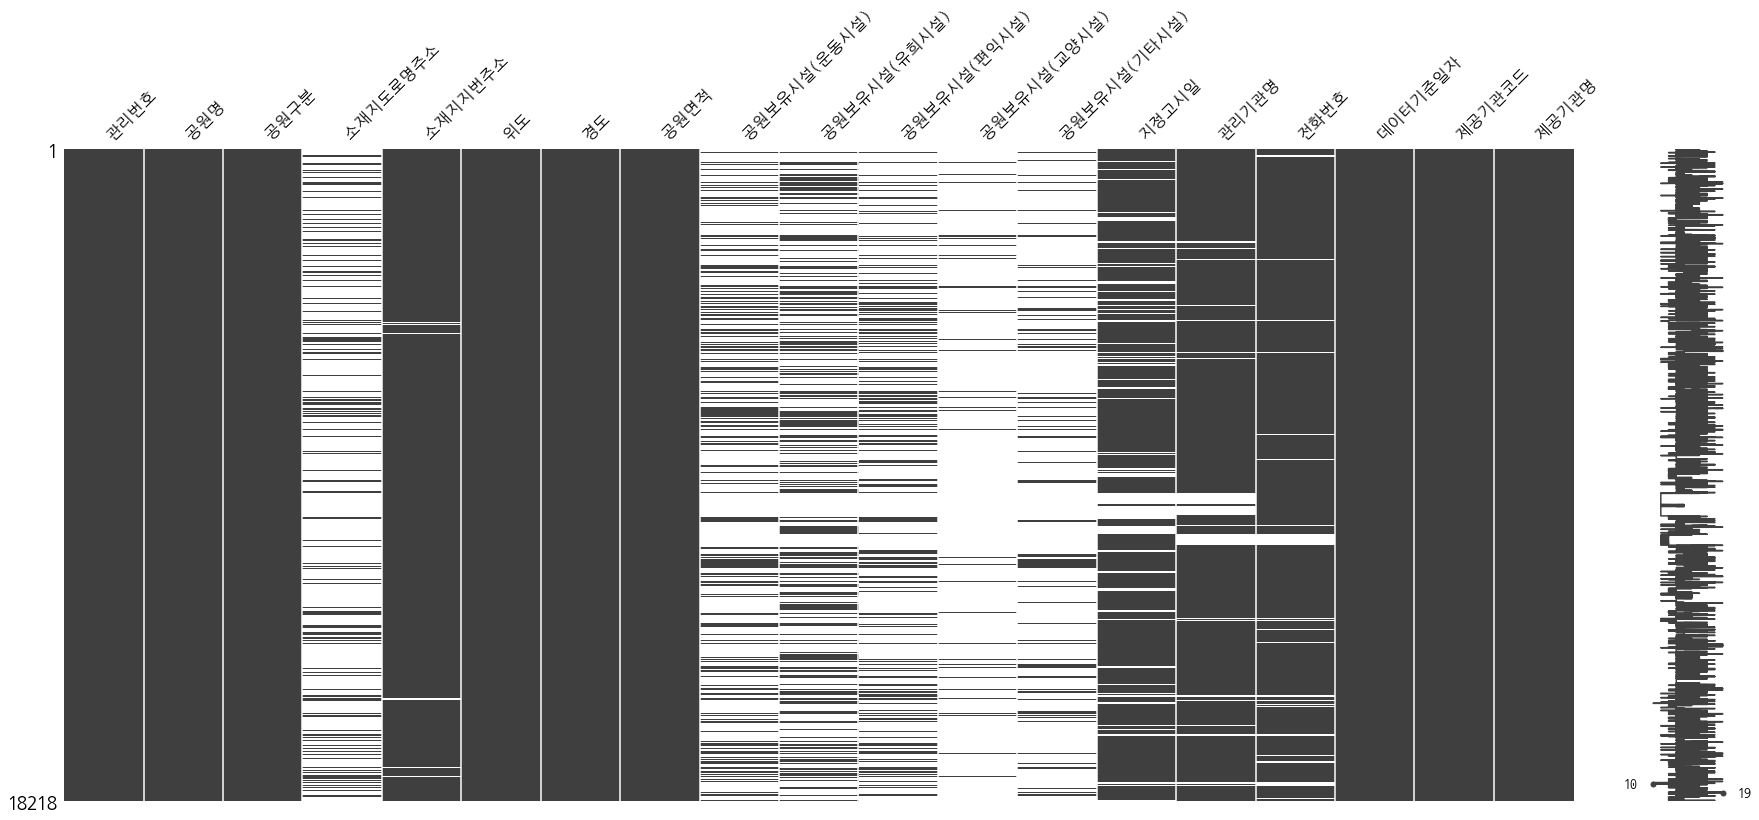

In [5]:
msno.matrix(park_202308, figsize=(30,12))
plt.show()

In [6]:
park_202308.columns

Index(['관리번호', '공원명', '공원구분', '소재지도로명주소', '소재지지번주소', '위도', '경도', '공원면적',
       '공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명', '전화번호', '데이터기준일자', '제공기관코드', '제공기관명'],
      dtype='object')

In [7]:
# drop() 메소드로 불필요한 컬럼을 제거한다.
park_202308.drop(columns=['공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명'], inplace=True)
park_202308

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명
0,41390-00084,승지공원,근린공원,경기도 시흥시 능곡중앙로 85,경기도 시흥시 능곡동 552,37.371378,126.813132,10842.0,031-310-3869,2022-11-28,4010000,경기도 시흥시
1,41570-00059,고촌어린이19(수기1공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1249,37.600127,126.767372,1715.0,031-980-5627,2022-10-18,4090000,경기도 김포시
2,41570-00060,고촌어린이20(수기2공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1260,37.596805,126.770145,1522.0,031-980-5627,2022-10-18,4090000,경기도 김포시
3,41570-00061,고촌어린이21(수기3공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1268,37.596252,126.767048,1567.0,031-980-5627,2022-10-18,4090000,경기도 김포시
4,41570-00063,항공소공원1,소공원,NaN,경기도 김포시 대곶면 대벽리 산66-56,37.617583,126.580436,1968.0,031-980-2344,2022-10-18,4090000,경기도 김포시
...,...,...,...,...,...,...,...,...,...,...,...,...
18213,11500-00044,꿈돌이,어린이공원,NaN,서울특별시 강서구 화곡동 24-128,37.546097,126.845352,1507.0,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18214,11500-00045,소나무,어린이공원,NaN,서울특별시 강서구 화곡동 29-31,37.547058,126.847807,942.0,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18215,11500-00046,산새,어린이공원,NaN,서울특별시 강서구 화곡동 772,37.546268,126.850385,539.0,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18216,11500-00047,박장,어린이공원,NaN,서울특별시 강서구 화곡동 56-25,37.540768,126.849087,929.0,02-2600-4202,2023-03-10,3150000,서울특별시 강서구


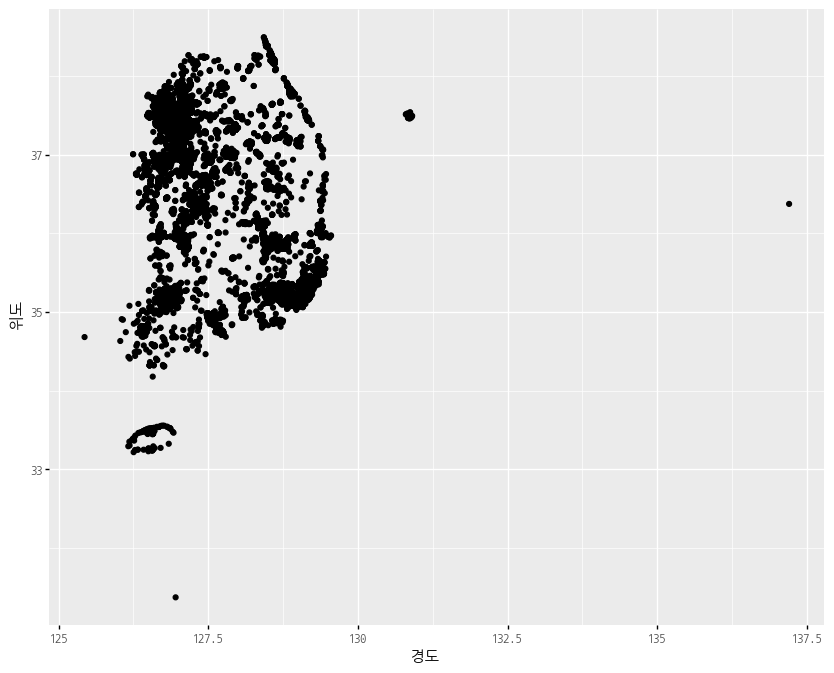

<ggplot: (-9223371879100933821)>

In [11]:
(
    ggplot(park_202308, aes(x='경도', y='위도'))
        + geom_point()
        + theme(text=element_text(family='NanumGothicCoding'), figure_size=(10, 8))
)

주소 전처리 => 도로명 주소가 NaN이면 지번 주소로 채운다.

In [18]:
# 도로명 주소가 NaN인 데이터의 개수 => 지번 주소만 입력된 데이터의 개수
# 도로명 주소만 입력되고 지번 주소가 입력되지 않은 데이터는 도로명 주소 제도가 실행되고 난 후 조성된 공원이다.
park_202308.소재지도로명주소.isnull().sum()

14559

In [25]:
# 도로명 주소는 입력되지 않고 지번 주소만 입력된 데이터의 개수
park_202308[park_202308.소재지도로명주소.isnull() & park_202308.소재지지번주소.notnull()]

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명
1,41570-00059,고촌어린이19(수기1공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1249,37.600127,126.767372,1715.0,031-980-5627,2022-10-18,4090000,경기도 김포시
2,41570-00060,고촌어린이20(수기2공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1260,37.596805,126.770145,1522.0,031-980-5627,2022-10-18,4090000,경기도 김포시
3,41570-00061,고촌어린이21(수기3공원),어린이공원,NaN,경기도 김포시 고촌읍 신곡리 1268,37.596252,126.767048,1567.0,031-980-5627,2022-10-18,4090000,경기도 김포시
4,41570-00063,항공소공원1,소공원,NaN,경기도 김포시 대곶면 대벽리 산66-56,37.617583,126.580436,1968.0,031-980-2344,2022-10-18,4090000,경기도 김포시
5,41570-00064,걸포어린이22,어린이공원,NaN,경기도 김포시 걸포동 1560,37.634949,126.705228,3450.0,031-980-5627,2022-10-18,4090000,경기도 김포시
...,...,...,...,...,...,...,...,...,...,...,...,...
18213,11500-00044,꿈돌이,어린이공원,NaN,서울특별시 강서구 화곡동 24-128,37.546097,126.845352,1507.0,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18214,11500-00045,소나무,어린이공원,NaN,서울특별시 강서구 화곡동 29-31,37.547058,126.847807,942.0,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18215,11500-00046,산새,어린이공원,NaN,서울특별시 강서구 화곡동 772,37.546268,126.850385,539.0,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
18216,11500-00047,박장,어린이공원,NaN,서울특별시 강서구 화곡동 56-25,37.540768,126.849087,929.0,02-2600-4202,2023-03-10,3150000,서울특별시 강서구
